### data preparation

In [1]:
import numpy as np
import scipy.io as scio
 
dataFile = 'datasets/ORL.mat'
data = scio.loadmat(dataFile)

In [2]:
x = data['X']
y = data['Y']

In [3]:
x.shape,y.shape

((400, 1024), (400, 1))

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
x = preprocessing.scale(x)
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.5)

In [5]:
#In the experiments, the data are normalized with zero mean and unit variance. 
#论文第四章说明

#For each data set, 50% of samples were randomly chosen as training data and the remaining samples were used as test data.
#论文4.1章说明

In [6]:
x = np.vstack((X_train,X_test))
y = np.vstack((y_train,y_test))
train_length = len(X_train)

---
### data initialization

In [7]:
#X data feature matrix ,包含训练集和测试集
X = x.T
n = len(x)
#Y_L labeled matrix
c = len(set(y.reshape(-1)))
Y = np.zeros((n,c))
for i in range(train_length):
    Y[i,y.reshape(-1)[i] - 1] = 1

Y_L = Y[:train_length]
# lamda and beta is hyper-parameters
#β is a trade-off parameter that balances feature selection and discriminative analysis
#λ is the regularization parameter
#γ is a very large positive parameter to ensure that the orthogonality is satisfied
beta = 1
lamda = 1
gamma = 10**10

In [8]:
Y.shape

(400, 40)

In [9]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def getAffinity_Matrix(data):
    # data是一个向量矩阵：euclidean代表欧式距离
    distA=pdist(data,metric='euclidean')
    # 将distA数组变成一个矩阵
    affinity = squareform(distA)
    return affinity

In [10]:
#Compute the similarity S and Laplacian matrix L

S = getAffinity_Matrix(X.T)

D = np.zeros(S.shape)
for i in range(len(D)):
    temp_ = 0
    for j in range(len(S)):
        temp_ += (S[i,j] + S[j,i])/2
    D[i,i] = temp_
    
L = D - (S + S.T)/2

In [11]:
#Initialize U and Z;
#where U is a diagonal matrix representing consistent constraints imposed on the labeled data, 
#with Uii equaling to a very large number (e.g., 10**10) 
#if i = 1, . . . , l and 0 if i = l + 1, . . . , n.
U = np.diag([0] * len(D))
for i in range(train_length):
    U[i,i] = 10**10

In [12]:
#where zk is an indicator vector representing whether a feature is chosen or not for the k-th class
K = len(set(y.reshape(-1)))
d = X.shape[0]
n = X.shape[1]
Z = np.zeros((d,K))
m = 200
#对每个特征随机生成m个被选择的特征
for i in range(K):
    Z[np.random.choice(np.arange(d), m,replace = False),i] = 1

#验证一下我们生成的Z是否正确。
k = np.random.choice(np.arange(K)) #随机抽取K的一列
Z_k = Z[:,k] #这一列赋值给Z_k
assert np.dot(Z_k,np.ones(d)) == m #详见论文公式5，Z_k.T*1_d = m

In [13]:
#G denotes the binary relationship between the i-th sample and the j-th class. 
#According to the definition of G, Gij = 1 or Gij = 0, and G1c = 1n
G = np.zeros((n,K))
for i in range(len(G)):
    G[i,y.reshape(-1)[i] - 1] = 1

#验证一下我们生成的初始值G是否正确。
assert (np.dot(G,np.ones(K)) == np.ones(n)).all() #详见论文公式3 G * 1_c = 1_n

In [14]:
#Thus, the integer constraints imposed on Z are also relaxed to real
#nonnegative constraints
Z = np.zeros((d,K))
for i in range(K):
    Z[:,i] = np.random.dirichlet(np.ones(d),size=1)
    
k = np.random.choice(np.arange(K)) #随机抽取K的一列
Z_k = Z[:,k] #这一列赋值给Z_k
assert np.round(np.dot(Z_k,np.ones(d)),4) == 1 #详见论文公式8，z_k >= 0, z_k.T * 1_d = 1.
#为什么需要round做一个近似，是因为程序里不存在绝对精准的数字，比如这里得到的浮点数是0.999999999999，所以需要做一个近似。

In [15]:
#The constraints imposed on G
#ensure that only one element in each row of G is equal to 1 and all the others are 0. Similar to [5], the
#nonnegative and orthogonal constraints imposed on G have the same properties. In fact, features are
#selected according to their importance.
for i in range(len(G)):
    temp1_ = y.reshape(-1)
    length_ = len(np.where(temp1_ == temp1_[i])[0])
    G[i,y.reshape(-1)[i] - 1] = 1/np.sqrt(length_)
assert (np.round(np.dot(G.T,G),4) == np.identity(K)).all() #详见论文公式8 G >= 0, G.T * G = I_c
#round理由同上。

---
### algorithm iteration

In [16]:
from tqdm import trange
import warnings
warnings.filterwarnings('ignore')

iterative_num = 50
W = np.zeros((d,K))
answer1 = []
answer2 = []
#answer3 = []
#answer4 = []
for i in trange(iterative_num):
    
    #更新W
    for k in range(K):
        z_k = Z[:,k] 
        g_k = G[:,k] 
        w_k = np.dot(np.dot(np.linalg.inv(np.dot(X,X.T) + lamda * np.diag(1/z_k)), X), g_k)
        W[:,k] = w_k
    
    #更新G
    for k in range(K):
        t_k = np.dot(np.dot(X.T,np.linalg.inv(np.dot(X,X.T) + lamda * np.diag(1/z_k))), X)
        g_k = G[:,k] 
        temp1_ = np.dot(t_k + beta * U + gamma * np.identity(n),g_k)
        temp2_ = np.dot(beta * (L + U) + gamma * np.dot(G,G.T), g_k)
        g_k = g_k * temp1_ / temp2_
        G[:,k] = g_k
    
    #更新Z
    for k in range(K):
        Z[:,k] = abs(W[:,k])/sum(abs(W[:,k]))    
    
    #计算目标函数
    temp1_ = 0
    for k in range(K):
        g_k = G[:,k]
        z_k = Z[:,k]
        temp_ = np.dot(np.dot(g_k.T,X.T),np.linalg.inv(np.dot(X,X.T) + lamda * np.diag(1/z_k)))
        temp_ = np.dot(np.dot(temp_,X),g_k)
        temp1_ += temp_         
    temp2_ = beta * ((np.trace(np.dot(np.dot(G.T,L),G))) + (np.trace(np.dot(np.dot((G-Y).T,U),G-Y))))
    #print(np.trace(np.dot(np.dot((G-Y).T,U),G-Y)))
    #print(np.trace(np.dot(np.dot(G.T,L),G)))
    #temp3_ = gamma/2 * np.linalg.norm(np.dot(G.T,G) - np.identity(K))
    #fai = ((G >= 0) * G).T
    #temp4_ = np.trace(np.dot(fai.T,G.T))
    #object_func = -temp1_ + temp2_ + temp3_ + temp4_
    #object_func = -temp1_
    #print(object_func)
    #print(temp1_,temp2_,temp3_,temp4_)
    answer1.append(temp1_)
    answer2.append(temp2_)
    #answer3.append(temp3_)
    #answer4.append(temp4_)
object_func = -np.array(answer1)*gamma + np.mean(np.array(answer2))
#参见公式11

100%|█████████████████████████████████████████| 50/50 [13:45<00:00, 16.51s/it]


---
### object function visualization

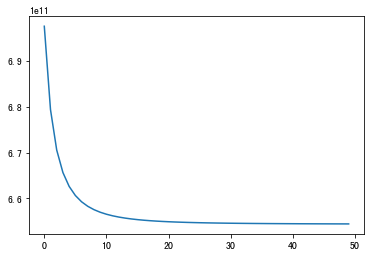

In [17]:
import matplotlib.pyplot as plt
plt.plot(object_func)

---
### prediction

In [18]:
#For any new data sample x, the found features are first chosen by using the learned zk for each class, and then, the
#probability score is predicted using wk. The class label is assigned to the one with the highest predicted probability.
#见论文公式13下的预测说明，本质上来说是直接应用上述迭代算法得到的软权重去直接预测。
test_predict = []
for mm in range(X_test.shape[0]):
    predict_c = []
    for i in range(c):
        predict_c.append(sum(X_test.T[:,mm] * Z[:,i] * W[:,i]))
    test_predict.append(np.argmax(predict_c) + 1)

In [19]:
predict_acc = sum(np.array(test_predict) == np.array(y_test).reshape(-1)) / len(np.array(y_test).reshape(-1))
print('prediction accuracy: ',predict_acc)

prediction accuracy:  0.93


In [20]:
#然后根据重要性矩阵筛选排名前m个特征，作为某个类别的预测输入。然后用ridge regression来做预测。针对每个类别做01预测，取概率最大的那个。
#The ridge regression model was used as the classifier to verify the performance of the methods in terms
#of their classification accuracy over unlabeled and test data.
#详见论文4.2最后的说明

from sklearn.linear_model import LogisticRegression
clf_l2_LR = LogisticRegression(penalty='l2')

m = 100
#针对每个类别取100个最重要的特征
answer_predict2 = [] 
for i in range(c):
    index_train1 = np.where(y_train == (i+1))[0]
    index_train2 = np.where(y_train != (i+1))[0]
    X_train1_ = X_train[index_train1]
    y_train1_ = y_train[index_train1]
    X_train2_ = X_train[index_train2]
    y_train2_ = np.zeros(y_train[index_train2].shape)    
    X_train_ = np.vstack((X_train1_,X_train2_))
    y_train_ = np.vstack((y_train1_,y_train2_))
    index_feature = np.argsort(W[:,i])[-m:]
    clf_l2_LR = LogisticRegression(penalty='l2')
    clf_l2_LR.fit(X_train_[:,index_feature],y_train_)
    predict_ans = clf_l2_LR.predict_proba(X_test[:,index_feature])
    answer_predict2.append(predict_ans[:,1])

In [21]:
predict_ans2 = np.argmax(np.array(answer_predict2),axis = 0) + 1

In [22]:
predict_acc2 = sum(predict_ans2 == np.array(y_test).reshape(-1)) / len(np.array(y_test).reshape(-1))
print('prediction accuracy: ',predict_acc2)

prediction accuracy:  0.76
